# Xpand IT DS Challenge

This notebook contains the template you should use to present your code, results and conclusions. You should keep the main structure intact to make it easier to evaluate and compare in the end.

In [1]:
#Libraries

import pandas as pd
import os
import numpy as np
import statistics as stats
import matplotlib.pyplot as plt
from scipy import stats

## Dataset
You can find the dataset in the data folder of the repository. The folder contains two files:
* dow_jones_index.data - dataset data
* dow_jones_index.names - dataset information and details

In [2]:
path = os.getcwd()
print(path)

c:\Users\Carolina\Desktop\CV\Python_challenges\DSU-Recruitment-Challenges


### Data Importation

In [3]:
# Read and close the file with with open()
with open(path +'\\data\\dow_jones_index.data','r') as data_file:
    # Define the column names (given by the 1st row of the data_file) 
    column_names = data_file.readline().strip().split(',')

    #Self-note: Once the first row is already been read and processed to obtain the column names, no need to do next(data_file), or it would skip the 1st row of values.

    # Create a nested array to store each row values 
    data_values = [row.strip().split(',') for row in data_file]
    
# Create a dataframe with the data
df = pd.DataFrame(data_values, columns=column_names)
df

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,,,$16.71,$15.97,-4.42849,26,0.182704
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223028,239655616,$16.19,$15.79,-2.47066,19,0.187852
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.02495926,242963398,$15.87,$16.13,1.63831,12,0.189994
3,1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.63831,9.355500109,138428495,$16.18,$17.14,5.93325,5,0.185989
4,1,AA,2/4/2011,$16.18,$17.39,$16.18,$17.14,154387761,5.93325,1.987451735,151379173,$17.33,$17.37,0.230814,97,0.175029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,2,XOM,5/27/2011,$80.22,$82.63,$80.07,$82.63,68230855,3.00424,-21.35571346,86758820,$83.28,$81.18,-2.52161,75,0.568801
746,2,XOM,6/3/2011,$83.28,$83.75,$80.18,$81.18,78616295,-2.52161,15.2210316,68230855,$80.93,$79.78,-1.42098,68,0.57896
747,2,XOM,6/10/2011,$80.93,$81.87,$79.72,$79.78,92380844,-1.42098,17.50851907,78616295,$80.00,$79.02,-1.225,61,0.58912
748,2,XOM,6/17/2011,$80.00,$80.82,$78.33,$79.02,100521400,-1.225,8.8119524,92380844,$78.65,$76.78,-2.37762,54,0.594786


### Initial dataset assessment
 - General Information
 - Missing values
 - Statistics

#### General Info

In [4]:
#Print information relative to df
df.info() # all variables are object Stype, i.e., str 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   quarter                             750 non-null    object
 1   stock                               750 non-null    object
 2   date                                750 non-null    object
 3   open                                750 non-null    object
 4   high                                750 non-null    object
 5   low                                 750 non-null    object
 6   close                               750 non-null    object
 7   volume                              750 non-null    object
 8   percent_change_price                750 non-null    object
 9   percent_change_volume_over_last_wk  750 non-null    object
 10  previous_weeks_volume               750 non-null    object
 11  next_weeks_open                     750 non-null    object

In [5]:
#Remove the $ sign from the data cells -> this is insufficient to convert str to numerical feature
df = df.applymap(lambda x: x.replace('$', '') if isinstance(x, str) else x)
df

C:\Users\Carolina\AppData\Local\Temp\ipykernel_11472\3616501523.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.replace('$', '') if isinstance(x, str) else x)


,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,15.82,16.72,15.78,16.42,239655616,3.79267,,,16.71,15.97,-4.42849,26,0.182704
1,1,AA,1/14/2011,16.71,16.71,15.64,15.97,242963398,-4.42849,1.380223028,239655616,16.19,15.79,-2.47066,19,0.187852
2,1,AA,1/21/2011,16.19,16.38,15.60,15.79,138428495,-2.47066,-43.02495926,242963398,15.87,16.13,1.63831,12,0.189994
3,1,AA,1/28/2011,15.87,16.63,15.82,16.13,151379173,1.63831,9.355500109,138428495,16.18,17.14,5.93325,5,0.185989
4,1,AA,2/4/2011,16.18,17.39,16.18,17.14,154387761,5.93325,1.987451735,151379173,17.33,17.37,0.230814,97,0.175029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,2,XOM,5/27/2011,80.22,82.63,80.07,82.63,68230855,3.00424,-21.35571346,86758820,83.28,81.18,-2.52161,75,0.568801
746,2,XOM,6/3/2011,83.28,83.75,80.18,81.18,78616295,-2.52161,15.2210316,68230855,80.93,79.78,-1.42098,68,0.57896
747,2,XOM,6/10/2011,80.93,81.87,79.72,79.78,92380844,-1.42098,17.50851907,78616295,80.00,79.02,-1.225,61,0.58912
748,2,XOM,6/17/2011,80.00,80.82,78.33,79.02,100521400,-1.225,8.8119524,92380844,78.65,76.78,-2.37762,54,0.594786


In [6]:
#The dataset has blank spaces on some data cells (given by '' in Python). Need to turn them into NaN first.
df.replace('', np.nan, inplace=True)
#Now that df has NaN instead of '', let us provide the number of NaNs per column
df.isna().sum()

quarter                                0
stock                                  0
date                                   0
open                                   0
high                                   0
low                                    0
close                                  0
volume                                 0
percent_change_price                   0
percent_change_volume_over_last_wk    30
previous_weeks_volume                 30
next_weeks_open                        0
next_weeks_close                       0
percent_change_next_weeks_price        0
days_to_next_dividend                  0
percent_return_next_dividend           0
dtype: int64

In [7]:
# Convert Numerical cols to Numerics and Date to Date
# 1. Numerical_cols_index will be a list with the indexes of the columns that will be converted to numerical features
numerical_cols_index = list(np.concatenate(([0], np.arange(3, 15)))) #list to provide commas between values (otherwise would be an array of numbers only)

# Convert selected columns to the 'category' data type
df.iloc[:, numerical_cols_index] = df.iloc[:, numerical_cols_index].astype('float')

# 2. Date column
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   quarter                             750 non-null    object        
 1   stock                               750 non-null    object        
 2   date                                750 non-null    datetime64[ns]
 3   open                                750 non-null    object        
 4   high                                750 non-null    object        
 5   low                                 750 non-null    object        
 6   close                               750 non-null    object        
 7   volume                              750 non-null    object        
 8   percent_change_price                750 non-null    object        
 9   percent_change_volume_over_last_wk  720 non-null    object        
 10  previous_weeks_volume     

#### MVs

 - The MVs are on columns (i) percent_change_volume_over_last_wk and (ii) previous_weeks_volume.
 - According to the file dow_jones_index.names, the variables are described as follows:
    1. previous_weeks_volume: the number of shares of stock that traded hands in the previous week.
    2. percent_change_volume_over_last_wk: the percentage change in the number of shares of stock that traded hands for this week compared to the previous week

##### Variable 'previous_weeks_volume' MVs' imputation

In [8]:
# The variable previous_weeks_volume can be obtained based on the previous week 'volume' variable value.
# Closer inspection at the variables 'previous_weeks_volume' and 'volume'
df[['previous_weeks_volume', 'volume']].head()

,previous_weeks_volume,volume
0,NaN,239655616.0
1,239655616.0,242963398.0
2,242963398.0,138428495.0
3,138428495.0,151379173.0
4,151379173.0,154387761.0


In [9]:
# We can use .fillna() and shift() to achieve the desired outcome.
# Fill NaNs in 'previous_weeks_volume' with values from 'volume' shifted by one index -> This will not work on the first MVs, as there are no previous volume recordd.
df['previous_weeks_volume'].fillna(df['volume'].shift(), inplace=True)
df[['previous_weeks_volume', 'volume']].head()

,previous_weeks_volume,volume
0,NaN,239655616.0
1,239655616.0,242963398.0
2,242963398.0,138428495.0
3,138428495.0,151379173.0
4,151379173.0,154387761.0


How to impute the reamining MV (at the beginning of the dataset)
 - Quicker Possibilities:
    1. Mean - viable if the values follow a Normal Distribution and there are no outliers (as mean is not robust against outliers)
    2. Median - viable if the distribution is skewed or there are outliers
 - Try, if there is time:
    3. K-NN

In [10]:
def assess_normality(column_values):
    # Create a figure to plot 2 plots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot histogram on the first axis
    axs[0].hist(column_values, bins=20, color='skyblue', edgecolor='black')
    axs[0].set_xlabel('Volume')
    axs[0].set_ylabel('Frequency')
    axs[0].set_title('Distribution of Volume')

    # Plot box plot on the second axis
    axs[1].boxplot(column_values, vert=False)
    axs[1].set_xlabel('Volume')
    axs[1].set_title('Box Plot of Volume')

    # Adjust layout
    plt.tight_layout()

    plt.show()

    # Perform Shapiro-Wilk test. H0: The data provides from a Normal Distribution
    statistic, p_value = stats.shapiro(column_values)
    #print(f'The Shapiro-Wilk Test statistic value is {statistic} and the p-value is {p_value}')

    # Define the usual significance level, alpha =5%
    alpha = 0.05
    # p-value measures the probability of obtaining the observed results, assuming that the null hypothesis is true.
    # The lower the p-value, thw the probability of obtaining the observed results, assuming that the null hypothesis is true.
    # The lower the p-value, the greater the statistical significance to reject H0.
    if p_value < alpha:
        print(f"The p-value {p_value} is lower than the significance level {alpha}. \nHence, there is statistical significance to reject H0, i.e., the data does not appear to be normally distributed.")
    else:
        print(f"The p-value {p_value} is greater than, or equal to, the significance level {alpha}. \nHence, there is not statistical significance to reject H0, i.e., the data appears to be normally distributed.")

In [11]:
# Save non-NaN observations of previous_weeks_volume into prev_weeks_vol_data series
prev_weeks_vol_data=df.dropna(subset=['previous_weeks_volume'])['previous_weeks_volume']

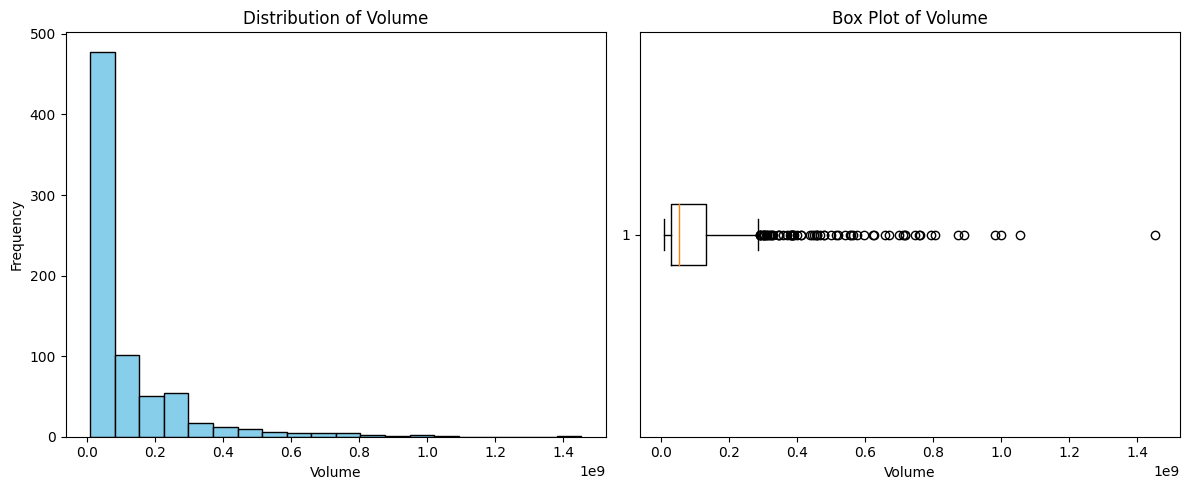

The p-value 2.2177548131108515e-37 is lower than the significance level 0.05. 
Hence, there is statistical significance to reject H0, i.e., the data does not appear to be normally distributed.


In [12]:
#Assess the distribution (and normality) of the desired column: prev_weeks_vol_data
assess_normality(prev_weeks_vol_data)

In [13]:
#The previous assessment leads to the imputation of the remaining MV of previous_weeks_volume with the median value of the variable. 
df['previous_weeks_volume'].fillna(df['previous_weeks_volume'].median(), inplace=True)
df.head()

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1.0,AA,2011-01-07,15.82,16.72,15.78,16.42,239655616.0,3.79267,NaN,52758908.0,16.71,15.97,-4.42849,26.0,0.182704
1,1.0,AA,2011-01-14,16.71,16.71,15.64,15.97,242963398.0,-4.42849,1.380223,239655616.0,16.19,15.79,-2.47066,19.0,0.187852
2,1.0,AA,2011-01-21,16.19,16.38,15.6,15.79,138428495.0,-2.47066,-43.024959,242963398.0,15.87,16.13,1.63831,12.0,0.189994
3,1.0,AA,2011-01-28,15.87,16.63,15.82,16.13,151379173.0,1.63831,9.3555,138428495.0,16.18,17.14,5.93325,5.0,0.185989
4,1.0,AA,2011-02-04,16.18,17.39,16.18,17.14,154387761.0,5.93325,1.987452,151379173.0,17.33,17.37,0.230814,97.0,0.175029


##### Variable 'percent_change_volume_over_last_week' MVs' imputation
 - percent_change_volume_over_last_wk: the percentage change in the number of shares of stock that traded hands for this week compared to the previous week

In [14]:
#We need volume variable again :)
#recall -> volume: the number of shares of stock that traded hands in the week
df[['volume', 'percent_change_volume_over_last_wk']]

,volume,percent_change_volume_over_last_wk
0,239655616.0,NaN
1,242963398.0,1.380223
2,138428495.0,-43.024959
3,151379173.0,9.3555
4,154387761.0,1.987452
...,...,...
745,68230855.0,-21.355713
746,78616295.0,15.221032
747,92380844.0,17.508519
748,100521400.0,8.811952


In [15]:
# Calculate the percentage change for each row where 'percent_change_volume_over_last_wk' is NaN
for i, row in df.iterrows():
    if i>0 and pd.isna(row['percent_change_volume_over_last_wk']):
        current_volume = row['volume']
        previous_volume = df.at[i - 1, 'volume']  # Get the volume from the previous row
        #"Regra de 3 simples" to reach the corresponding percentage of the new week, compared to the old. Need to remove the old week value: will be 100%
        percent_change = ((current_volume*100) / previous_volume) - 100
        df.at[i, 'percent_change_volume_over_last_wk'] = percent_change
df[['volume', 'percent_change_volume_over_last_wk']].head()

,volume,percent_change_volume_over_last_wk
0,239655616.0,NaN
1,242963398.0,1.380223
2,138428495.0,-43.024959
3,151379173.0,9.3555
4,154387761.0,1.987452


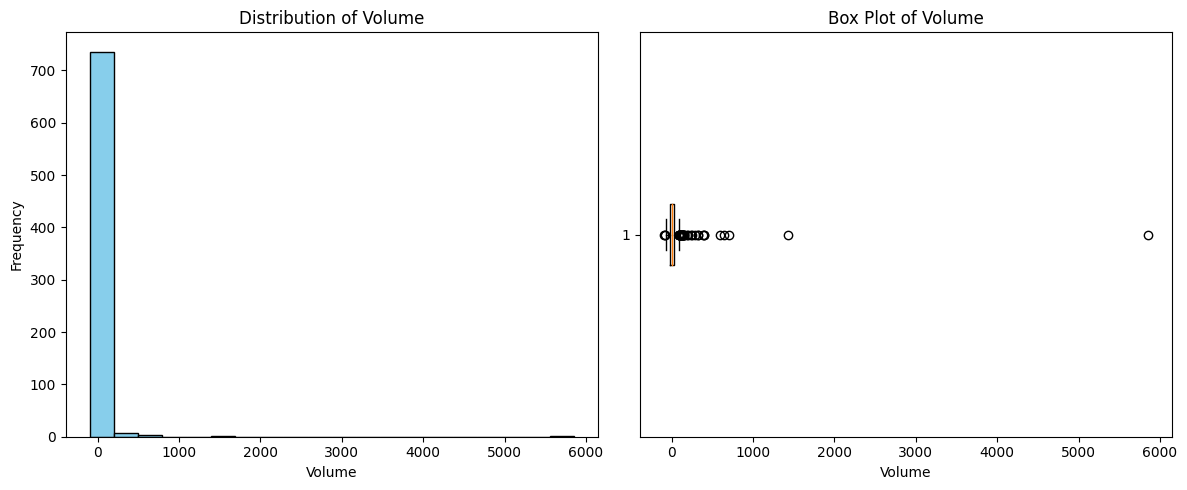

The p-value 0.0 is lower than the significance level 0.05. 
Hence, there is statistical significance to reject H0, i.e., the data does not appear to be normally distributed.


In [16]:
# Save non-NaN observations of previous_weeks_volume into prev_weeks_vol_data series
percent_change_volume_over_last_wk_data=df.dropna(subset=['percent_change_volume_over_last_wk'])['percent_change_volume_over_last_wk']

#Assess the distribution (and normality) of the desired column: prev_weeks_vol_data
assess_normality(percent_change_volume_over_last_wk_data)

In [17]:
#The previous assessment leads to the imputation of the remaining MV of previous_weeks_volume with the median value of the variable. 
df['percent_change_volume_over_last_wk'].fillna(df['percent_change_volume_over_last_wk'].median(), inplace=True)
df.head()

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1.0,AA,2011-01-07,15.82,16.72,15.78,16.42,239655616.0,3.79267,0.934330,52758908.0,16.71,15.97,-4.42849,26.0,0.182704
1,1.0,AA,2011-01-14,16.71,16.71,15.64,15.97,242963398.0,-4.42849,1.380223,239655616.0,16.19,15.79,-2.47066,19.0,0.187852
2,1.0,AA,2011-01-21,16.19,16.38,15.6,15.79,138428495.0,-2.47066,-43.024959,242963398.0,15.87,16.13,1.63831,12.0,0.189994
3,1.0,AA,2011-01-28,15.87,16.63,15.82,16.13,151379173.0,1.63831,9.355500,138428495.0,16.18,17.14,5.93325,5.0,0.185989
4,1.0,AA,2011-02-04,16.18,17.39,16.18,17.14,154387761.0,5.93325,1.987452,151379173.0,17.33,17.37,0.230814,97.0,0.175029


# For Tomorrow: Fix the Object data types 

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   quarter                             750 non-null    object        
 1   stock                               750 non-null    object        
 2   date                                750 non-null    datetime64[ns]
 3   open                                750 non-null    object        
 4   high                                750 non-null    object        
 5   low                                 750 non-null    object        
 6   close                               750 non-null    object        
 7   volume                              750 non-null    object        
 8   percent_change_price                750 non-null    object        
 9   percent_change_volume_over_last_wk  750 non-null    float64       
 10  previous_weeks_volume     

#### Statistics

In [19]:
df.describe()

,date,percent_change_volume_over_last_wk,previous_weeks_volume
count,750,750.000000,7.500000e+02
mean,2011-03-31 23:02:24,19.607898,1.168275e+08
min,2011-01-07 00:00:00,-96.636950,9.718851e+06
25%,2011-02-18 00:00:00,-20.220722,3.063918e+07
50%,2011-04-01 00:00:00,0.934330,5.275891e+07
75%,2011-05-13 00:00:00,23.063086,1.327218e+08
max,2011-06-24 00:00:00,5850.973288,1.453439e+09
std,NaN,228.601675,1.584332e+08


In [20]:
#df['teste']=df['volume']+1
#df['teste']
#df.drop(columns={'teste'})

## Business Analysis
Here you should conduct a brief analysis of what is Dow Jones Index. You can enumerate the main topics to take into account based on the dataset provided as well as your understandings of the variables.


-----
*Add here your business analysis conclusions (max. 200 words)*

-----


[Key Words]:
 - Time Series
 - Stock Prices
 - Prediction
 - LSTMs (Long Short Term Memory) - often refered in the literature
 - ARIMA / SARIMA (Auto Regressive Integrated Moving Average) / (Seasonal Auto Regressive Integrated Moving Average) - Baseline method

References:
1. https://archive.ics.uci.edu/dataset/312/dow+jones+index
2. https://www.semanticscholar.org/paper/Dynamic-Radius-Species-Conserving-Genetic-Algorithm-Brown-Pelosi/24d692e537b28b1fd13a18c0c93f0df6ef4e2047
3. https://neptune.ai/blog/predicting-stock-prices-using-machine-learning
4. https://www.researchgate.net/publication/268513448_Weekly_Dow_Jones_Index_Data

Other resources:
5. https://rpubs.com/AbhaJha/984077

## Data Understanding
During the data understanding phase, you should focus on understanding what each variable represents, compute statistics and visualizations. Some questions that may guide your work follow:
* Feature engineering: should new features be created from the existing ones?
* What will be your features and your label?
* Is the dataset ready for the prediction task? (ex: missing values)
* How will the data be split into train and test sets?

-----

In [ ]:
#add here your imports

In [ ]:
#add here your data understanting code

-----
*Add here your data understanding findings and conclusions (max. 200 words)*

-----

## Modelling
In this phase, your main goal is to develop and describe your approach to the solution of the problem. Some guidelines to help you:
* What metrics will you use to evaluate your solutions?
* What are some algorithms that can lead to good results? And why?
* Describe in detail your thought process during the development of your solution.
* Present your results.


-----


In [ ]:
#add here your modelling code

-----
*Add here your modelling results and conclusions (max. 200 words)*

-----

## Conclusions
In the conclusions, you should enumerate the results you got after completing the challenge.
* How good do you consider your results? 
* What are some factors that would contribute to get better results?
* What are some advantages and disadvantages of your solution?
* What can be done as future work to improve your results?


-----
*Add here your final conclusions (max. 400 words)*

-----

#### Feedback

-----
*Add here your thoughts and feedback regarding this challenge.*

-----

To submit your solution you should e-mail us this notebook in response to the e-mail you initially received with the challenge.